<a href="https://colab.research.google.com/github/DongUk-Park/RnD/blob/main/POI/NAIS/DataPreprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import json
import csv
import os
import pandas as pd
import numpy as np
import random
import copy
from datetime import datetime

#Data Untils

## RAW Data 생성

### Check_in Data 생성
리뷰 데이터로 체크인 데이터(user,business_id)를 만든다 <br>
원하는 데이터 정보 추가,삭제 : 13, 21 수정

In [9]:
from datetime import datetime

date_time_str = '2018-07-07 22:09:11'
# 문자열을 datetime 객체로 파싱
date_time_obj = datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S')

# datetime 객체를 timestamp로 변환 (초 단위)
timestamp = int(date_time_obj.timestamp())

print(timestamp)


1531001351


In [ ]:
# JSON 파일 경로
json_file_path = '/content/drive/MyDrive/dataset/yelp_dataset/review.json'

# CSV 파일 경로
csv_file_path = '/content/checkin.csv'

# CSV 파일을 쓰기 모드로 열기
with open(csv_file_path, 'w', newline='') as csv_file:
    # CSV 라이터 생성
    csv_writer = csv.writer(csv_file)

    # CSV 파일 헤더 작성
    csv_writer.writerow(['user_id', 'business_id','date'])

    # JSON 파일을 한 줄씩 읽어서 처리
    with open(json_file_path, 'r', encoding='utf-8') as json_file:
        for line in json_file:
            data = json.loads(line)  # JSON 데이터 파싱

            # user_id와 business_id 추출
            user_id = data['user_id']
            business_id = data['business_id']
            date_time_str = data['date']
            date_time_obj = datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S')

            date = int(date_time_obj.timestamp())
            #print(date_time_str, date_time_obj)
            # CSV 파일에 데이터 작성
            csv_writer.writerow([user_id, business_id])

print("checkin_data 생성 완료.")


In [ ]:
"""
데이터 개수(row 수) 확인
"""

# CSV 파일 경로
csv_file_path = '/content/checkin.csv'

row_count = 0

# CSV 파일을 읽기 모드로 열고 행 수를 센다
with open(csv_file_path, 'r', newline='') as csv_file:
    csv_reader = csv.reader(csv_file)
    next(csv_reader)  # 헤더 행을 건너뜁니다.
    for row in csv_reader:
        row_count += 1

print(f"CSV 파일의 행 수: {row_count}")

### Business_info Data 생성
Business 데이터로 가게의 위치를 담은 데이터(business_id,location, city)를 만든다 <br>
원하는 데이터 정보 추가,삭제 : 13, 21 수정

In [ ]:
# JSON 파일 경로
json_file_path = '/content/drive/MyDrive/dataset/yelp_dataset/business.json'

# CSV 파일 경로
csv_file_path = '/content/business_info.csv'

# CSV 파일을 쓰기 모드로 열기
with open(csv_file_path, 'w', newline='') as csv_file:
    # CSV 라이터 생성
    csv_writer = csv.writer(csv_file)

    # CSV 파일 헤더 작성
    csv_writer.writerow(['business_id','latitude ','longitute', 'city'])

    # business_id 를 int형으로 변환
    idx = 0

    # JSON 파일을 한 줄씩 읽어서 처리
    with open(json_file_path, 'r', encoding='utf-8') as json_file:
        for line in json_file:
            data = json.loads(line)  # JSON 데이터 파싱

            # user_id와 business_id 추출
            business_id = data['business_id']
            latitude = data['latitude']
            longitude = data['longitude']
            city = data['city']

            # CSV 파일에 데이터 작성
            csv_writer.writerow([business_id, latitude, longitude, city])
            idx += 1

print("CSV 파일 생성 완료.")


In [ ]:
"""
데이터 개수(row 수) 확인
"""
# CSV 파일 경로
csv_file_path = '/content/business_info.csv'

row_count = 0

# CSV 파일을 읽기 모드로 열고 행 수를 센다
with open(csv_file_path, 'r', newline='') as csv_file:
    csv_reader = csv.reader(csv_file)
    next(csv_reader)  # 헤더 행을 건너뜁니다.
    for row in csv_reader:
        row_count += 1

print(f"CSV 파일의 행 수: {row_count}")

## 사용자 방문데이터(위치포함) 생성
위에서 생성한 데이터 두개를 합친 방문데이터 생성 <br>
checkin + business_info => location과 city 확인<br>
Philadelphia 도시에 대한 데이터만 남김

In [ ]:
# business_info.csv 파일 경로
business_info_file = '/content/business_info.csv'

# checkin_data.csv 파일 경로
checkin_data_file = '/content/checkin.csv'

# 새로운 CSV 파일 경로 (결과 저장용)
output_file = '/content/checkin_data_in_philadelphia.csv'

# business_id를 키로 한 dictionary 생성
business_location = {}
with open(business_info_file, 'r', newline='') as business_file:
    csv_reader = csv.reader(business_file)
    next(csv_reader)  # 헤더 행 건너뛰기
    for row in csv_reader:
        business_id, latitude, longitude, city = row[0], row[1], row[2], row[3].lower() #city : 소문자로 받음
        business_location[business_id] = (latitude, longitude, city)

count = 0 # 잘 다 들어갔는지 체크
mcount = 0 # 잘 안들어간거 있는지 체크
not_phila = 0

# 새로운 CSV 파일(output_file : checkin_data_in_philadelphia)을 작성하여 business_id, latitude, longitude를 추가
with open(checkin_data_file, 'r', newline='') as checkin_file, open(output_file, 'w', newline='') as output_csv:
    csv_reader = csv.reader(checkin_file)
    csv_writer = csv.writer(output_csv)

    # 헤더 행 작성
    header = next(csv_reader)
    header.extend(['business_id', 'latitude', 'longitude', 'city'])
    csv_writer.writerow(header)

    for row in csv_reader:
        business_id = row[1]
        if business_id in business_location:
            latitude, longitude, city = business_location[business_id]

            # city가 "philadelphia"인 경우에만 데이터를 CSV 파일에 작성
            if "philadelphia" in city: #philadelphia 에서 오타가 존재할 수 있기 때문에 "phila"만 검사
              row.extend([latitude, longitude, city])
              csv_writer.writerow(row)
              count += 1
            else:
              not_phila += 1
        else:
            # 해당 business_id가 business_info.csv에 없을 경우, 스킵
            mcount += 1
            continue

print("CSV 파일에 위치 정보가 추가되었습니다.")
print(count, mcount, not_phila) #philadelphia, 에러, 다른도시


user_id 순으로 정렬

In [ ]:
# CSV 파일 경로
input_file = '/content/checkin_data_in_philadelphia.csv'
output_file = '/content/checkin_data_final.csv'

# CSV 파일을 읽고 데이터를 리스트로 저장
data = []
with open(input_file, 'r', newline='') as csv_file:
    csv_reader = csv.reader(csv_file)
    header = next(csv_reader)  # 헤더 행
    #data.append(header)
    for row in csv_reader:
        data.append(row)

# user_id를 기준으로 데이터를 정렬
data.sort(key=lambda x: x[0])  # 여기서 0은 user_id 열을 가리킵니다. 0부터 시작하면 첫 번째 열입니다.

# user_id를 정수형으로 변환
idx = 0
before_user_id = data[0][0]
for i in data:
  if i[0] == before_user_id:
    i[0] = idx
  else:
    idx += 1
    before_user_id = i[0]
    i[0] = idx

# business_id 기준으로 데이터를 정렬
data.sort(key=lambda x: x[1])  # 여기서 0은 user_id 열을 가리킵니다. 0부터 시작하면 첫 번째 열입니다.
print(data[:3])

# business_id 정수형으로 변환
idx = 0
before_business_id = data[0][1]
for i in data:
  if i[1] == before_business_id:
    i[1] = idx
  else:
    idx += 1
    before_business_id = i[1]
    i[1] = idx

print(data[:3])

# 다시 유저 번호 기준으로 정렬
data.sort(key=lambda x: x[0])
print(data[:3])

# 정렬된 데이터를 새로운 파일에 저장
with open(output_file, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerows(data)

print("CSV 파일이 user_id를 기준으로 정렬되었고, 새로운 파일에 저장되었습니다.")

In [ ]:
data.sort(key=lambda x: x[1])

column =['user_id', 'business_id', 'latitude', 'longitude', 'city']
df = pd.DataFrame(data, columns=column)
# 중복되지 않는 '키' 값을 찾고 필터링
result = df.drop_duplicates('business_id', keep='first')[['business_id', 'latitude', 'longitude', 'city']].values.tolist()
print(len(result))

with open('/content/business_info_in_philadelphia.csv', 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerows(result)

14586


In [ ]:
"""
train에 사용될 history 데이터 (2차원 리스트)
인덱스 번호 : user_Id
인덱스 value(list형식) : 해당 uesr가 방문한 business_id 리스트
"""
data.sort(key=lambda x: x[0])

history_list = []
tmp = []
before_user_id = 0
for idx, i in enumerate(data):
  if i[0] == before_user_id:
    tmp.append(i[1])
  else:
    tmp = list(dict.fromkeys(tmp)) # dictionary key 특성을 이용한 중복제거
    if len(tmp) >= 10: # 중복이 제거된 방문 횟수가 10회가 넘는 유저만 append
      history_list.append(tmp)

    tmp = []
    tmp.append(i[1])
    before_user_id += 1

  if idx == len(data) - 1:
    if len(tmp) >= 10:
      history_list.append(tmp)

output_file = '/content/history_list.csv'
with open(output_file, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerows(history_list)

In [ ]:
print(history_list[-1])

[850, 1647, 2165, 3302, 3532, 3886, 4702, 4925, 5580, 6101, 7254, 9889, 12381, 12957, 13661, 14337, 14510]


## Test,Validation,Train Data 생성

In [ ]:
business_info = pd.read_csv('/content/business_info_in_philadelphia.csv', names = ['business_id','latitude','longitude','city'])
print(business_info)
business_id_list = business_info['business_id'].tolist()
latitude_list = business_info['latitude'].tolist()
longitude_list = business_info['longitude'].tolist()

       business_id   latitude  longitude          city
0                0  40.028160 -75.033803  philadelphia
1                1  39.952584 -75.165222  philadelphia
2                2  39.967439 -75.175452  philadelphia
3                3  39.923048 -75.178078  philadelphia
4                4  39.948508 -75.161969  philadelphia
...            ...        ...        ...           ...
14581        14581  40.060970 -75.167412  philadelphia
14582        14582  40.022691 -75.208956  philadelphia
14583        14583  39.982937 -75.154732  philadelphia
14584        14584  39.936582 -75.162655  philadelphia
14585        14585  39.949183 -75.164777  philadelphia

[14586 rows x 4 columns]


In [ ]:
"""
위 history_list를 train, validation, test 데이터셋으로 분리시킴
"""
train_ratio = 0.6
test_ratio = 0.2
validation_ratio = 0.2

train_dataset = []
test_dataset = []
validation_dataset = []

train_negative_dataset = []
test_negative_dataset = []
validation_negative_dataset = []


#아래의 결과를 csv 파일로 저장할 경로, 총 6개의 파일 생성
output_train = '/content/history_train.csv'
output_validation = '/content/history_validation.csv'
output_test = '/content/history_test.csv'

output_train_negative = '/content/history_train_negative.csv'
output_validation_negative = '/content/history_validation_negative.csv'
output_test_negative = '/content/history_test_negative.csv'


for user, history in enumerate(history_list):
  negative_list = [num for num in business_id_list if num not in history]

  ### 한 유저에 대해 train,validation,test dataset 생성
  total_samples = len(history) # 방문 횟수 저장
  random.shuffle(history) # 방문 기록 순서를 랜덤하게 섞어준다.

  train_size = int(total_samples * train_ratio)
  validation_size = int(total_samples * validation_ratio)

  list_train = history[:train_size]
  list_validation = history[train_size: (train_size + validation_size)]
  list_test = history[(train_size + validation_size):]


  train_dataset.append(list_train)
  validation_dataset.append(list_validation)
  test_dataset.append(list_test)

  total_samples = len(negative_list) # 방문 횟수 저장
  random.shuffle(negative_list) # 방문 기록 순서를 랜덤하게 섞어준다.

  train_size = int(total_samples * train_ratio)
  validation_size = int(total_samples * validation_ratio)

  negative_list_train = negative_list[:train_size]
  negative_list_validation = negative_list[train_size: (train_size + validation_size)]
  negative_list_test = negative_list[(train_size + validation_size):]

  train_negative_dataset.append(negative_list_train)
  validation_negative_dataset.append(negative_list_validation)
  test_negative_dataset.append(negative_list_test)

with open(output_train, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerows(train_dataset)
with open(output_validation, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerows(validation_dataset)
with open(output_test, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerows(test_dataset)

with open(output_train_negative, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerows(train_negative_dataset)
with open(output_validation_negative, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerows(validation_negative_dataset)
with open(output_test_negative, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerows(test_negative_dataset)

## 거리 데이터 생성

In [ ]:
# Haversine 거리 계산 함수
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # 지구 반지름 (km)
    return c * r

def distance_prob(x):
  a, b = 0.02059073981980995 , -2.4172468185424805
  if x == 0.0:
    return 0
  y = a * (x**b)

  if y>1:
    y = 1
  return y

In [ ]:
# with open('/content/distanceArray.csv', 'w', newline='') as csv_file:
#     csv_writer = csv.writer(csv_file)
#     for i in range(len(business_id_list)):
#       result = []
#       for j in range(len(business_id_list)):
#         dist_i = haversine(latitude_list[i],longitude_list[i],latitude_list[j], longitude_list[j])
#         result.append(dist_i)
#       csv_writer.writerow(result)

In [ ]:
# history_distance = []
# for user, user_visited_list in enumerate(train_dataset):
#   result = [] # 유저 히스토리에 대한 거리를 저장할 변수
#   #print(idx)
#   user_visited_list *= 5
#   user_distance = []
#   for b_id in user_visited_list:
#     my_lat = latitude_list[b_id]
#     my_long = longitude_list[b_id]
#     tmp_dist = []
#     for near_b_id in user_visited_list:
#       n = haversine(my_lat, my_long, latitude_list[near_b_id], longitude_list[near_b_id])
#       if n != 0:
#         tmp_dist.append(n)
#     user_distance.append(min(tmp_dist))
#   history_distance.append(user_distance)
# print(history_distance[:2])

In [ ]:
# """### distance_prob"""
# print(len(train_dataset), len(history_distance))
# print(len(train_dataset[0]), len(history_distance[0]))

# target_distance_prob = []
# for li in history_distance:
#   tmp = []
#   for i in li:
#     tmp.append(distance_prob(i))
#   target_distance_prob.append(tmp)


## Linear Regression

In [ ]:
# 데이터 불러오기
header = ["user_id", "item", "latitude", "longitude", "city"]
checkin_data_with_distance = pd.read_csv('checkin_data_final.csv', names=header)

checkin_data_with_distance['closest_distance'] = 0

before_userID = None
result = []

#거리 계산
for index, user_row in checkin_data_with_distance.iterrows():
    userID = user_row['user_id']
    if before_userID != userID:
      same_user_df = checkin_data_with_distance[checkin_data_with_distance['user_id'] == userID]
      before_userID = userID
    if same_user_df.shape[0] < 10:
      continue # 10 보다 작은건 건너띔 -> 실제로 쓰는 데이터는

    sum = 0
    count = 0

    user_item = user_row['item']
    user_lat = user_row['latitude']
    user_lon = user_row['longitude']
    closest_distance = 9999999  # 초기값을 무한대로 설정

    for poi_index, poi_row in same_user_df.iterrows():
        poi_item = poi_row['item']
        poi_lat = poi_row['latitude']
        poi_lon = poi_row['longitude']

        # Haversine 거리 계산
        distance = haversine(user_lat, user_lon, poi_lat, poi_lon)
        count += 1
        sum += distance
        # 현재 POI와의 거리가 가장 작은지 확인
        # if distance < closest_distance and distance != 0:
        #     closest_distance = distance
            #print(closest_distance)
    avg = sum / (count-1)
    # # 방문한 Poi가 하나밖에 없다면 거리 : 0, 근데 그런거 없음
    # if closest_distance == 9999999:
    #   closest_distance = 0

    #print(f"{index} : {closest_distance}")
    result.append(avg)

print(result)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
# 리스트를 Pandas DataFrame으로 변환
data = pd.DataFrame(result, columns=['distance'])

# 결과 출력
print(data)
data.to_csv('/content/distance_list.csv', index=False)

        distance
0       2.699622
1       1.942037
2       2.019781
3       2.468640
4       2.657665
...          ...
465581  1.821751
465582  2.332291
465583  9.212375
465584  2.795973
465585  2.274835

[465586 rows x 1 columns]


In [ ]:
data = data.sort_values(by='distance')
data

,distance
261824,0.081316
261817,0.081316
261818,0.081316
261819,0.081316
261820,0.081316
...,...
124143,33.234151
353542,41.848788
26100,42.005040
292052,43.249681


         distance  rounded_distance  log_rounded_distance
261824   0.081316               0.1             -3.321928
261817   0.081316               0.1             -3.321928
261818   0.081316               0.1             -3.321928
261819   0.081316               0.1             -3.321928
261820   0.081316               0.1             -3.321928
...           ...               ...                   ...
124143  33.234151              33.2              5.053111
353542  41.848788              41.8              5.385431
26100   42.005040              42.0              5.392317
292052  43.249681              43.2              5.432959
137043  45.292676              45.3              5.501439

[465586 rows x 3 columns]
0.925999    15871
1.000000    15608
1.070389    14741
1.137504    14651
1.201634    13935
            ...  
4.705978        1
4.694880        1
4.689299        1
4.672425        1
5.501439        1
Name: log_rounded_distance, Length: 258, dtype: int64
[4.68702011e-02 4.6093510

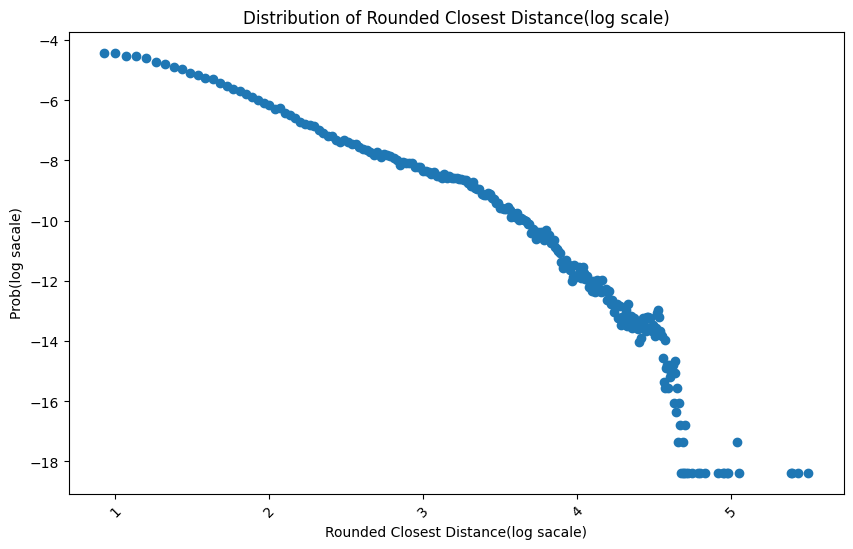

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data['rounded_distance'] = data['distance'].round(1)
# 로그를 취할 열 추가(ground_truth)
data['log_rounded_distance'] = np.log2(data['rounded_distance'])
#data = data[data['log_rounded_distance'] != -np.inf] #반올림 결과가 0인 데이터 95183개 삭제


distance_counts = data['log_rounded_distance'].value_counts() # 거리별 방문횟수 저장
#distance_counts.iloc[0] += 95183 # 0인 애들을 카운트가 가장 많은, 즉 가장 가까운 곳으로 다 더해줌
#distance_counts.loc[distance_counts.index < 0.847997] = 16356 # 더 가까운애들은 최대 확률로 설정
distance_counts = distance_counts[distance_counts.index >= 0.847997] # 더 가까운애들은 삭제
total_counts = distance_counts.sum()

print(data)
print(distance_counts)
print(distance_counts.values / total_counts)
print("Counts의 합:", total_counts)

distance_counts_values_prob = distance_counts.values / total_counts
x1 = distance_counts.index # log2(distance)
y1 = np.log2(distance_counts_values_prob)

#print(x1)
#print(y1)

# 그래프 그리기
plt.figure(figsize=(10, 6))  # 그래프 크기 설정 (선택 사항)
plt.scatter(x1, y1)
plt.xlabel('Rounded Closest Distance(log sacale)')
plt.ylabel('Prob(log sacale)')
plt.title('Distribution of Rounded Closest Distance(log scale)')
#plt.ylim(0, 0.005)
#plt.xlim(0,1)
plt.xticks(rotation=45)  # x축 레이블 회전 (선택 사항)
plt.show()

In [ ]:
import torch
import torch.nn

X = torch.tensor(x1, dtype=torch.float32).view(-1, 1)
y = torch.tensor(y1, dtype=torch.float32).view(-1, 1)  # 확률, 2D 텐서로 변환

In [ ]:
# 모델 정의
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.w1 = nn.Parameter(torch.randn(1, requires_grad=True))
        self.w2 = nn.Parameter(torch.randn(1, requires_grad=True))

    def forward(self, x):
        return self.w1 + self.w2 * x

model = MyModel()
criterion = nn.MSELoss()  # 평균 제곱 오차 손실 함수
optimizer = optim.SGD(model.parameters(), lr=0.01)  # 확률적 경사 하강법 사용

# 학습
num_epochs = 1000  # 학습 에포크 수
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    #if (epoch + 1) % 100 == 0:
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# 학습된 파라미터 출력
print(f'학습된 파라미터 w1: {model.w1.item():.4f}, w2: {model.w2.item():.4f}')

Epoch [1/1000], Loss: 59.5336
Epoch [2/1000], Loss: 29.6815
Epoch [3/1000], Loss: 15.1983
Epoch [4/1000], Loss: 8.1714
Epoch [5/1000], Loss: 4.7620
Epoch [6/1000], Loss: 3.1077
Epoch [7/1000], Loss: 2.3049
Epoch [8/1000], Loss: 1.9153
Epoch [9/1000], Loss: 1.7260
Epoch [10/1000], Loss: 1.6340
Epoch [11/1000], Loss: 1.5891
Epoch [12/1000], Loss: 1.5672
Epoch [13/1000], Loss: 1.5563
Epoch [14/1000], Loss: 1.5508
Epoch [15/1000], Loss: 1.5480
Epoch [16/1000], Loss: 1.5464
Epoch [17/1000], Loss: 1.5454
Epoch [18/1000], Loss: 1.5448
Epoch [19/1000], Loss: 1.5442
Epoch [20/1000], Loss: 1.5438
Epoch [21/1000], Loss: 1.5434
Epoch [22/1000], Loss: 1.5430
Epoch [23/1000], Loss: 1.5426
Epoch [24/1000], Loss: 1.5422
Epoch [25/1000], Loss: 1.5418
Epoch [26/1000], Loss: 1.5414
Epoch [27/1000], Loss: 1.5411
Epoch [28/1000], Loss: 1.5407
Epoch [29/1000], Loss: 1.5403
Epoch [30/1000], Loss: 1.5399
Epoch [31/1000], Loss: 1.5396
Epoch [32/1000], Loss: 1.5392
Epoch [33/1000], Loss: 1.5388
Epoch [34/1000],

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50444 (\N{HANGUL SYLLABLE SSYI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50868 (\N{HANGUL SYLLABLE UN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44163 (\N{HANGUL SYLLABLE GEOS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


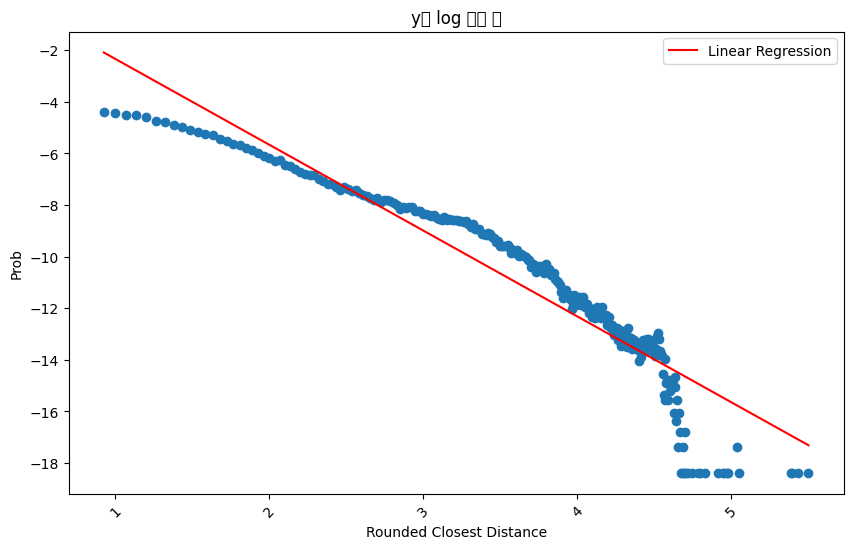

In [ ]:
# 선형 회귀 결과를 그래프로 표현
plt.figure(figsize=(10, 6))

plt.scatter(x1, y1)

# 선형 회귀 결과
plt.plot(X, model.w1.item() + model.w2.item() * X , color='red', label='Linear Regression')

plt.xlabel('Rounded Closest Distance')
plt.ylabel('Prob')
plt.title('y에 log 씌운 것')
plt.xticks(rotation=45)

plt.legend()
plt.show()

In [ ]:
b = model.w2.item()
#a = np.exp(model.w1.item())
a = 2 ** model.w1.item()

print(a,b)

x1 = np.arange(40)
x = x1 + 0.5
#print(x)
y = a * (x**b)
print(y)

1.9831419706017246 -3.326113700866699
[1.98890390e+01 5.14818632e-01 9.41369430e-02 3.07412575e-02
 1.33258437e-02 6.83633476e-03 3.92203579e-03 2.43669150e-03
 1.60694415e-03 1.11002798e-03 7.95723322e-04 5.87965964e-04
 4.45560193e-04 3.44933339e-04 2.71964227e-04 2.17858865e-04
 1.76955383e-04 1.45501651e-04 1.20947406e-04 1.01520094e-04
 8.59629511e-05 7.33688968e-05 6.30726396e-05 5.45790792e-05
 4.75148607e-05 4.15950108e-05 3.65995887e-05 3.23571016e-05
 2.87325641e-05 2.56187928e-05 2.29299852e-05 2.05969325e-05
 1.85634138e-05 1.67834554e-05 1.52192287e-05 1.38394248e-05
 1.26179878e-05 1.15331208e-05 1.05664999e-05 9.70264924e-06]
